In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import threading
import queue
from typing import TypeVar, Dict, Callable, Tuple, Union, List, Generic
Fn = Callable

%matplotlib inline
%load_ext line_profiler

In [2]:
Action = int
Player = int
State = TypeVar('State')
c_puct: float = 10.0

def sample(it):
    rand = np.random.sample()
    t = 0.0
    if isinstance(it, dict):
        it = it.items()
    else:
        it = enumerate(it)
    for i, f in it:
        t = t + f
        if rand <= t:
            return i
        
debug = False
    
class MCTSNode(Generic[State]):
    def __init__(self, state: State, probs: np.ndarray, v: float, player: Player) -> None:
        self.state: State = state
        self.player = player
        if not np.any(probs):
            self.terminal = True
            self.value = v
            return
        
        self.terminal = False
        self.actions = np.flatnonzero(probs)
        self.inv_actions = np.empty_like(probs, dtype=np.int)
        self.inv_actions[self.actions] = np.arange(self.actions.size)
        
        self.N: np.ndarray = np.zeros_like(self.actions, dtype=np.int)
        self.W: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.Q: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.P: np.ndarray = probs[self.actions]
        
        self.total_visits: int = 1
        self.children: List[MCTSNode] = [None] * probs.size
            
    def select_action(self) -> Action:
        if not self.actions.size:
            return None
        
        root_total = math.sqrt(self.total_visits)
        
        selection_priorities = self.Q + c_puct * root_total * self.P / (1 + self.N)
        if debug:
            print(self.state, selection_priorities)
        return self.actions[np.argmax(selection_priorities)]
    
    def backup(self, a, v, p):
        self.total_visits = self.total_visits + 1
        idx = self.inv_actions[a]
        self.N[idx] = self.N[idx] + 1
        self.W[idx] = self.W[idx] + (v if p == self.player else -v)
        self.Q[idx] = self.W[idx] / self.N[idx]
    
    def probs(self, temp) -> np.ndarray:
        if temp == 0.0:
            ret = np.zeros_like(self.inv_actions)
            ret[self.actions[np.argmax(self.N)]] = 1.0
            return ret
        exps = self.N ** (1.0 / temp)
        ret = np.zeros_like(self.inv_actions, dtype=np.float)
        ret[self.actions] = exps / np.sum(exps)
        return ret
    
class Game(Generic[State]):
    def __init__(self):
        self.num_players = 2
    def gen_root(self) -> State:
        raise NotImplemented   
    def do_action(self, state: State, action: Action) -> Tuple[State, Player]:
        raise NotImplemented   
    def get_actions(self, state: State, player: Player) -> List[Action]:
        raise NotImplemented   
    def end(self, state: State, player: Player) -> Player:
        raise NotImplemented
    
class MCTSPlayer(Generic[State]):
    def __init__(self,
                 game: Game[State],
                 eval_state: Fn[[State, Player], Tuple[np.ndarray, float]]):
        self.game = game
        self.eval_state = eval_state
        
    def take_turn(self, root_node: MCTSNode, search_size: int) -> MCTSNode:
        for _ in range(search_size):
            cur_node = root_node
            history: List[Tuple[MCTSNode, Action]] = []

            while cur_node and not cur_node.terminal:
                action = cur_node.select_action()
                history.append((cur_node, action))
                cur_node = cur_node.children[action]

            value: float
            player: int
            if cur_node:
                value = cur_node.value
                player = cur_node.player
            else:
                prev_node = history[-1][0]
                action = history[-1][1]
                new_state, player = self.game.do_action(
                    prev_node.state, action, prev_node.player)
                probs, value = self.eval_state(new_state, player)
                new_node = MCTSNode(new_state, probs, value, player)
                prev_node.children[action] = new_node

            for i, (node, act) in enumerate(reversed(history)):
                node.backup(act, value, player)
    
    def play_self(self, search_size: int, temp: float = 0.0) -> List[Tuple[State, np.ndarray, float, Player]]:
        root_state, root_player = self.game.gen_root()
        probs, value = self.eval_state(root_state, root_player)
        cur_node = MCTSNode(root_state, probs, value, root_player)
        history: List[Tuple[State, np.ndarray]] = []
        
        while not cur_node.terminal:
            self.take_turn(cur_node, search_size)
            probs = cur_node.probs(temp)
            next_act = sample(probs)
            
            history.append((cur_node, probs))
            
            cur_node = cur_node.children[next_act]
            
        history.append((cur_node, None))
        r = cur_node.value
        fin_player = cur_node.player
        
        return list(reversed([(n.state, p, r if n.player == fin_player else -r, n.player)
                              for i, (n, p) in enumerate(reversed(history))]))


In [3]:
TTTState = Tuple[np.ndarray, int]

class TTT(Game[TTTState]):
    _board_shape = (9,)
    
    def __init__(self):
        super().__init__()
        
    def gen_root(self) -> Tuple[TTTState, Player]:
        return np.zeros(TTT._board_shape, dtype=np.int), 1

    def do_action(self, s: TTTState, a: Action, p: Player) -> Tuple[TTTState, Player]:
        new_board = np.copy(s)
        new_board[a] = p
        return (new_board, -p)

    def get_actions(self, board: TTTState, _: Player) -> np.ndarray:
        return np.nonzero(board == 0)[0]

    _end_idx = sum([[3 * i, 3 * i + 1, 3 * i + 2, i, i + 3, i + 6 ] for i in range(3)], [])
    _end_idx = np.array(_end_idx + [2, 4, 6, 0, 4, 8])
    _inv_end_idx = np.array(sum([[3 * i, i] for i in range(3)], []) + [2, 0])
    def end(self, board: TTTState, player: Player) -> Player:
        z = np.flatnonzero(np.abs(np.sum(board[TTT._end_idx].reshape(8, 3), axis=1)) == 3)
        if z.size:
            return board[TTT._inv_end_idx[z[0]]] * player

        if np.all(board):
            return 0.0

        return None
    
ttt = TTT()
def ttt_eval_state(s: TTTState, p: Player) -> Tuple[np.ndarray, float]:
    end = ttt.end(s, p)
    if end != None:
        return (np.zeros(TTT._board_shape), end)
    acts = np.zeros(TTT._board_shape)
    valid_acts = ttt.get_actions(s, p)
    acts[valid_acts] = 1.0 / valid_acts.size
    return (acts, 0.0)

Wall time: 4.39 s


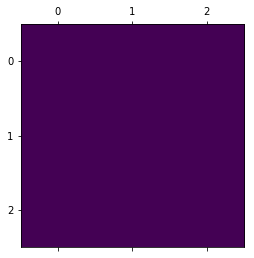

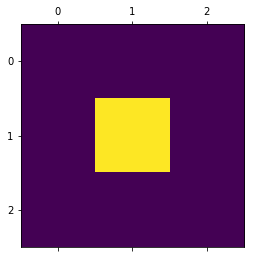

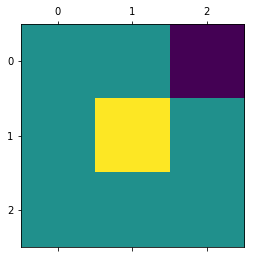

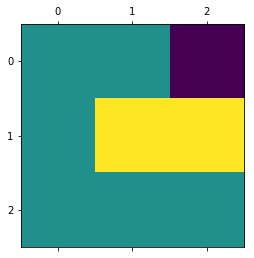

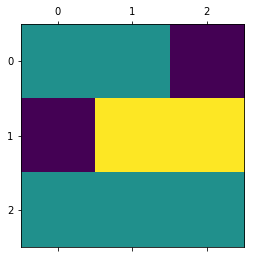

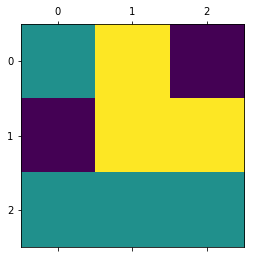

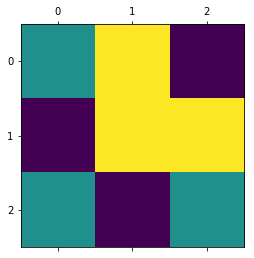

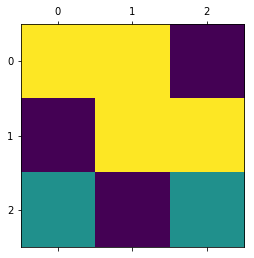

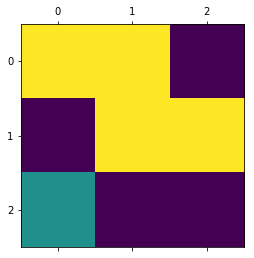

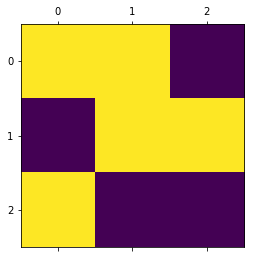

In [4]:
%%time

for s, _, _, _ in MCTSPlayer(ttt, ttt_eval_state).play_self(10000):
    plt.matshow(s.reshape(3, 3))

In [5]:
def softmax(x):
    if len(x.shape) == 1:
        exped = np.exp(x - np.max(x))
        return exped / exped.sum()
    else:
        mx = np.max(x, axis=1)
        mx = mx.reshape((1,) + mx.shape).transpose()
        exped = np.exp(x - mx)
        denom = np.sum(exped, axis=1)
        denom = denom.reshape((1,) + denom.shape).transpose()
        return exped / denom

class ExpertIterationTrainer(Generic[State]):
    def __init__(self,
                 mk_eval_feed_dict: Fn[[List[State]], Dict[tf.Tensor, np.ndarray]],
                 mk_train_feed_dict: Fn[[List[Tuple[np.ndarray, float]]], 
                                        Dict[tf.Tensor, np.ndarray]],
                 actions: tf.Tensor,
                 value: tf.Tensor,
                 optimizer: tf.train.Optimizer,
                 graph: tf.Graph,
                 game: Game[State],
                 num_iterations: int,
                 iteration_size: int = 100,
                 search_size: int = 100):
        self.mk_eval_feed_dict = mk_eval_feed_dict
        self.mk_train_feed_dict = mk_train_feed_dict
        self.actions = actions
        self.value = value
        self.optimizer = optimizer
        self.graph = graph
        self.game = game
        self.num_iterations = num_iterations
        self.iteration_size = iteration_size
        self.search_size = search_size
        
    def train_player(self):
        with tf.Session(graph=self.graph) as sess:
            tf.global_variables_initializer().run()
            
            player = MCTSPlayer(self.game, lambda s, p: self.eval_state(sess, s, p))
            example_games = [player.play_self(1)]
            new_probs = [self.eval_state(sess, res[0], res[3]) for res in example_games[-1]]
            example_probs = [new_probs]
            all_states, all_labels = [], []
            states = []
            labels = []
            for i in range(self.num_iterations):
                positions = self.play_games(sess)
                states.append(list(map(lambda g: g[0], positions)))
                labels.append(list(map(lambda g: (g[1], g[2]), positions)))
                all_states.append(states[-1])
                all_labels.append(labels[-1])
                if len(states) > 10:
                    states = states[1:]
                    labels = labels[1:]
                self.train_on(sum(states, []), sum(labels, []))

                example_games.append(player.play_self(1))
                new_probs = [self.eval_state(sess, res[0], res[3]) for res in example_games[-1]]
                example_probs.append(new_probs)
                print('finished step %d' % i)
                
        return example_games, all_states, all_labels, example_probs
    
    def play_games(self, sess: tf.Session) -> List[Tuple[State, np.ndarray, float]]:
        
        work_q = queue.Queue()
        result_q = queue.Queue()
        go = queue.Queue()
        alive = [self.iteration_size]
        in_q = [0]
        counter_lock = threading.Lock()
        
        def mp_play_self():
            my_q = queue.Queue()

            def eval_state(state: State, p: Player) -> Tuple[np.ndarray, float]:
                with counter_lock:
                    work_q.put(((state, p), my_q))
                    in_q[0] += 1
                    if alive[0] == in_q[0]:
                        go.put(True)
                return my_q.get()

            player = MCTSPlayer(self.game, eval_state)
            result = player.play_self(self.search_size, 1.0)
            with counter_lock:
                alive[0] -= 1
                result_q.put(result)
                if alive[0] == 0:
                    go.put(False)
                elif alive[0] == in_q[0]:
                    go.put(True)
        
        for _ in range(self.iteration_size):
            threading.Thread(target=mp_play_self).start()

        while go.get():
            with counter_lock:
                ret_qs = []
                states = []
                players = []
                for _ in range(in_q[0]):
                    (state, player), ret_q = work_q.get_nowait()
                    end = self.game.end(state, player)
                    if end != None:
                        ret_q.put((np.zeros(self.actions.shape[1:].as_list()), end))
                    else: 
                        ret_qs.append(ret_q)
                        states.append(state)
                        players.append(player)
                in_q[0] = 0
                if len(states) > 0:
                    a, v = self.eval_states(sess, states, players)
                    for j, ret_q in enumerate(ret_qs):
                        ret_q.put((a[j], v[j]))
                        
        positions = []
        while not result_q.empty():
            positions += result_q.get_nowait()[:-1]
        return positions
    
    def train_on(self, 
                 states: List[State], 
                 labels: List[Tuple[np.ndarray, float]]):
        for i in range(1000):
            select = np.random.choice(np.arange(len(states)), 64)
            select_states = [states[j] for j in select]
            select_labels = [labels[j] for j in select]
            
            feed = {**self.mk_eval_feed_dict(select_states), 
                    **self.mk_train_feed_dict(select_labels)}

            optimizer.run(feed_dict=feed)
        

    def eval_states(self, 
                    sess: tf.Session, 
                    states: List[State],
                    players: List[Player]) -> Tuple[np.ndarray, np.ndarray]:
        feed = self.mk_eval_feed_dict(states)
        actions, value = sess.run([self.actions, self.value], feed_dict=feed)
        for i in range(actions.shape[0]):
            action = actions[i]
            poss_actions = self.game.get_actions(states[i], players[i])
            mask = np.ones_like(action, dtype=bool)
            mask[poss_actions] = False
            action[mask] = 0.0
            action[poss_actions] = softmax(action[poss_actions])

        return (actions, value)

    def eval_state(self, sess: tf.Session, state: State, player: Player) -> Tuple[np.ndarray, float]:
        end = self.game.end(state, player)
        if end != None:
            return (np.zeros(self.actions.shape[1:].as_list()), end)
        a, v = self.eval_states(sess, [state], [player])
        return a[0], v[0][0]

In [6]:
l2_loss_coeff = 0.01
hidden_size = 100

graph = tf.Graph()
with graph.as_default():
    ttt_hw = tf.Variable(tf.truncated_normal([9, hidden_size]))
    ttt_hb = tf.Variable(tf.zeros([hidden_size]))
    
    ttt_aw = tf.Variable(tf.truncated_normal([hidden_size, 9]))
    ttt_ab = tf.Variable(tf.zeros([9]))
    
    ttt_vw = tf.Variable(tf.truncated_normal([hidden_size, 1]))
    ttt_vb = tf.Variable(tf.zeros([1]))
    
    weights = [ttt_hw, ttt_hb, ttt_aw, ttt_ab, ttt_vw, ttt_vb]
    
    tf_boards = tf.placeholder(tf.float32, shape=[None, 9])
    hidden = tf.nn.relu(tf.matmul(tf_boards, ttt_hw) + ttt_hb)
    actions = tf.matmul(hidden, ttt_aw) + ttt_ab
    value = tf.tanh(tf.matmul(hidden, ttt_vw) + ttt_vb)
    
    tf_probs = tf.placeholder(tf.float32, shape=[None, 9])
    tf_zs = tf.placeholder(tf.float32, shape=[None])
    
    loss = tf.reduce_mean(tf.square(tf_zs - value))
    loss = loss + tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_probs, logits=actions))
    for w in weights:
        loss = loss + l2_loss_coeff * tf.nn.l2_loss(w)
        
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [7]:
def mk_eval_feed_dict(states: List[State]):
    return { tf_boards: np.array(states) }

def mk_train_feed_dict(vals: List[Tuple[np.ndarray, float]]):
    probs, zs = tuple([list(t) for t in zip(*vals)])
    return { tf_probs: np.array(probs),
             tf_zs: np.array(zs) }

trainer = ExpertIterationTrainer(mk_eval_feed_dict, mk_train_feed_dict,
                                 actions, value, optimizer,
                                 graph, ttt, 5)

finished step 0
finished step 1
finished step 2
finished step 3
finished step 4
Wall time: 1min 3s


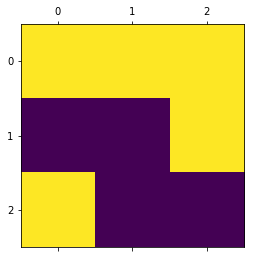

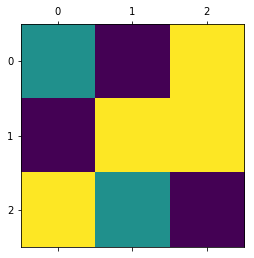

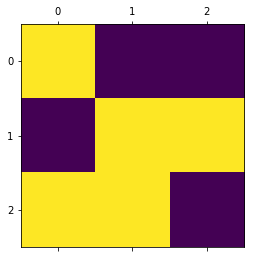

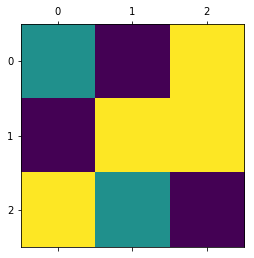

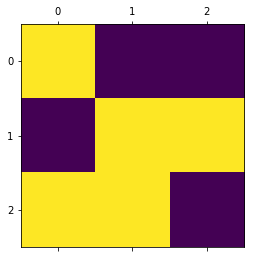

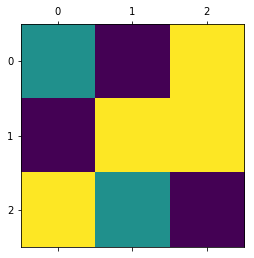

In [8]:
%%time

examples, states, labels, probs = trainer.train_player()
for g in examples[::1]:
    plt.matshow(g[-1][0].reshape(3, 3))